In [83]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch as pt
import csv
import pickle #to save notebook at sessions


#from Bojar lab format
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

#set path for pickles to be saved in
pickle_path = '/Users/erikazhang/Dropbox (MIT)/20.440 Biological Networks/project/python pickles/'
output_path = '/Users/erikazhang/Dropbox (MIT)/20.440 Biological Networks/project/output/'

# Defining key functions


In [3]:
# Parameters for grid search

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(200, 800, step=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(10, 50, step=10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [4]:
def model_evaluation(model, x, y):
#     print(f"Accuracy for 'PHA-L high' class: {100*(model.score(x[y==1], y[y==1])):>4f}%")
#     print(f"Accuracy for 'PHA-L low' class: {100*(model.score(x[y==0], y[y==0])):>4f}%")
#     print(f"Overall accuracy: {100*(model.score(x, y)):>4f}%")
    
    model_predict = model.predict(x)
    model_predict_prob = model.predict_proba(x)
    
    high = f"{100*(model.score(x[y==1], y[y==1])):>4f}%"
    low = f'{100*(model.score(x[y==0], y[y==0])):>4f}%'
    total = f'{100*(model.score(x, y)):>4f}%'

    avg_loss = log_loss(y, model_predict_prob)
    roc_auc = roc_auc_score(y, model_predict)
    f1 = f1_score(y, model_predict)
    return high, low, total, avg_loss, roc_auc, f1

In [66]:
'''
Generate training, validation, and test set from original full df using scikit learn 
saves best estimator model as a pickle

Input: 
- dataframe with PHA-L column (binary) and transcripts
- name of pickle file to contain model (str) 
- df to add model stats to
- bool: True or False based on whether you want to save model as pickle or not. True for save, False for not

Output: 
- high, low, total accuracy of best estimator model 
'''
def train_and_evaluate(data, name, df, boo):
    #y: PHA-L score array
    y = data['PHA-L'].values 

    #X: glycogene transcript data array
    x = data.iloc[:, :-3].values

    # Split training, validation and test set
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.1, random_state=42, stratify=y)

    encoder = LabelEncoder()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)
    
    
    ''''Use RandomSearchCV to optimize hyperparameters'''
    #takes a while to run!!
    model = RandomForestClassifier()

    model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, 
                                      n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)

    model_random.fit(x_train, y_train)
    
    mod = model_random.best_estimator_
    
    if boo:    
        # save pickle 
        with open(pickle_path + name +'.pkl', 'wb') as f:
            pickle.dump(mod, f)
        f.close()
    
    high, low, total, avg_loss, roc_auc, f1 = model_evaluation(mod, x_test, y_test)
    
    '''
    extract top 5 important genes and append to dataframe
    ''' 
    
    feature_importances = pd.DataFrame({'feature': data.columns[:-3], 
                                        'importance': mod.feature_importances_})

    # Sort the dataframe by importance score in descending order
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    feature_importances['combo'] = feature_importances['feature'] + ': '+ feature_importances['importance'].round(4).astype(str)
    

    # make new column that combines feature name with its importance value, get top 5 as string to add to dictionary
    top10p_df = feature_importances.head(26)
    top10p = str(list(top10p_df['combo']))
    
    #adds model information to dataframe called 'model_comp'
    df.loc[len(df.index)] = [name, high, low, total, top10p, avg_loss, roc_auc, f1] 

    
    return high, low, total

# #load pickled model via: 
# pickle_in = open("pickle_path + TILmodel_all_robust.pkl","rb")
# TILmodel_all_robust = pickle.load(pickle_in)

# Random Forest Clustering using all T-cells and all genes
to build model(S) --> build on all T-cells, and then by T-cell subtypes
https://github.com/BojarLab/scGlycomics_b16_branching/blob/main/Random%20Forest%20-%20Apr%208%202022%20-%20RQ.ipynb

In [ ]:
'''
load pickled dataframe containing:
- robust normalized gene expression counts
- glycoscores
- all genes + type + biotin + L-PHA in columns
- cell barcodes of T-cells in rows
'''

pickle_in = open("pickle_path + full_TIL_glyconorm.pkl","rb")
full_TIL_glyconorm = pickle.load(pickle_in)

In [69]:
# make dataframe comparing different transformation types
cols = {"Model": [], "PHA-L high accuracy": [], "PHA-L low accuracy": [], 
        "Overall accuracy": [], 'Top 5 features': [], 'Average loss': [], 
        'ROC AUC score': [], 'F1 score': []}
model_comp = pd.DataFrame(columns = cols)

In [52]:
train_and_evaluate(full_df, 'allgenes_TIL_model.pkl', model_comp, True)

NameError: name 'full_df' is not defined

# Random Forest Clustering using all T-cells but only glycogenes
to build model(S) --> build on all T-cells, and then by T-cell subtypes
https://github.com/BojarLab/scGlycomics_b16_branching/blob/main/Random%20Forest%20-%20Apr%208%202022%20-%20RQ.ipynb

In [30]:
'''Load glycosorted, normalized dataframe from pickle, saved from glycogene filtering raw.ipynb

Dataframes have:
- gene names as columns (241 glycogenes,housekeeping incl.) +columns for type, biotin, PHA-L = 244 columns total
- cell barcodes as row index, for cells identified as T-cells via ProjecTILs package in R
- genes are columns, normalized via robust scaler +3 columns for info 
'''

# ## load updated df from pickle
pickle_in = open(pickle_path +"glycoTIL_normscored.pkl","rb")
glycoTIL_normscored = pickle.load(pickle_in)

pickle_in = open(pickle_path +"glycoLN_normscored.pkl","rb")
glycoLN_normscored = pickle.load(pickle_in)

In [31]:
#make copies of dataframes to not accidentally change original df
glycoTIL = glycoTIL_normscored.copy()
glycoLN = glycoLN_normscored.copy()

In [32]:
#make df version without housekeeping genes(25)
glycoTIL_no_hk = glycoTIL.copy()
glycoLN_no_hk = glycoLN.copy()
housekeeping_list = ['Ahsa1', 'Api5', 'Atp6v1e1', 'Bcap31', 'Cops6', 'Csnk2b', 'Eif3i', 'Eif4g2', 'Gdi2', 'Hnrnpf', 
                     'Hnrnph1', 'Hnrnph2', 'Ilf2', 'Dnajc5', 'Ncl', 'Otub1', 'Pdap1', 'Polr2f', 'Rhoa', 'Srp14', 
                     'Srrm1', 'Timm44', 'Ttc1', 'Ywhab', 'Pdcd6']
cols_to_remove = glycoTIL_no_hk.columns.intersection(housekeeping_list)
glycoTIL_no_hk.drop(columns=cols_to_remove, inplace=True) #now have 236 glycogenes
glycoLN_no_hk.drop(columns=cols_to_remove, inplace=True)

In [70]:
#train and test model on all TILs with housekeeping genes
train_and_evaluate(glycoTIL, 'allglycoTIL_whk_model.pkl', model_comp, True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


('80.691057%', '90.020367%', '85.350966%')

In [71]:
#train and test model on all TILs WITHOUT housekeeping genes
train_and_evaluate(glycoTIL_no_hk, 'allglycoTIL_nohk_model.pkl', model_comp, True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


('77.032520%', '90.020367%', '83.519837%')

In [72]:
#train and test model on all LNs with housekeeping genes
train_and_evaluate(glycoLN_no_hk, 'allglycoLN_whk_model.pkl', model_comp, True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


('75.327103%', '83.238095%', '79.245283%')

In [73]:
#train and test model on all LNs WITHOUT housekeeping genes
train_and_evaluate(glycoLN_no_hk, 'allglycoLN_nohk_model.pkl', model_comp, True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


('72.897196%', '85.904762%', '79.339623%')

In [87]:
model_comp

,Model,PHA-L high accuracy,PHA-L low accuracy,Overall accuracy,Top 5 features,Average loss,ROC AUC score,F1 score
0,allglycoTIL_whk_model.pkl,80.691057%,90.020367%,85.350966%,"['Rhoa: 0.0783', 'Srp14: 0.0736', 'Csnk2b: 0.0...",0.386397,0.853557,0.846482
1,allglycoTIL_nohk_model.pkl,77.032520%,90.020367%,83.519837%,"['B4galnt1: 0.066', 'Stt3a: 0.0522', 'Lfng: 0....",0.395558,0.835264,0.823913
2,allglycoLN_whk_model.pkl,75.327103%,83.238095%,79.245283%,"['B4galnt1: 0.0969', 'Lfng: 0.0359', 'B3gnt2: ...",0.476583,0.792826,0.785575
3,allglycoLN_nohk_model.pkl,72.897196%,85.904762%,79.339623%,"['B4galnt1: 0.0931', 'Lfng: 0.0362', 'B3gnt2: ...",0.481786,0.794010,0.780781


In [84]:
model_comp.to_csv(output_path+'model_comparison_TILandLNglyco.csv', index=False)

## 2. Test if a random set of 264 genes perform any better or worse at predicting glycosylation compared to the glycogene set
Is the model just performing good bc its 264 genes or because they're the glycogenes?

In [37]:
'''
full TIL glyconorm df contains just T-cells but all genes, normalized and glycoscored
rows are the barcodes, columns are the genes
'''
#**takes forever!!

# open pickle 
with open(pickle_path + 'full_TIL_glyconorm.pkl', 'wb') as f:
    full_TIL_glyconorm = pickle.load(f)

In [10]:
# make dataframe comparing different transformation types
cols = {"Transformation": [], "PHA-L high accuracy": [], 
        "PHA-L low accuracy": [], "Overall accuracy": [], 
        'Average loss': [], 'ROC AUC score': [],
        'F1 score': [], 'Top 5 features': []}
random_comp = pd.DataFrame(columns = cols)

In [38]:
TIL_type_df

,AAACCTGAGATGGCGT-1,AAACCTGAGCGAGAAA-1,AAACCTGAGCTGGAAC-1,AAACCTGAGGATTCGG-1,AAACCTGAGTCTCAAC-1,AAACCTGCAAATACAG-1,AAACCTGCAAGCCCAC-1,AAACCTGCAATAGAGT-1,AAACCTGCAGATCCAT-1,AAACCTGCAGATGGGT-1,...,TTTGTCATCAACACGT-1,TTTGTCATCAAGGTAA-1,TTTGTCATCAGAAATG-1,TTTGTCATCAGGCAAG-1,TTTGTCATCAGTGTTG-1,TTTGTCATCATGTCTT-1,TTTGTCATCCAATGGT-1,TTTGTCATCGGATGGA-1,TTTGTCATCTACTTAC-1,TTTGTCATCTAGCACA-1
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sox17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAAA01118383.1,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,2,0,0,0,0
Vmn2r122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CAAA01147332.1,1,1,0,0,0,3,4,0,0,0,...,0,2,2,0,0,0,0,0,1,0
Biotin,1052,799,231,507,197,440,2265,227,221,1014,...,1185,1078,329,260,204,221,173,247,174,361


In [ ]:
import random

# spits out normalized df with genes in 
random_TIL = full_TIL_glyconorm.copy()
random_LN = full_LN_glyconorm.copy()

for i in np.arange(3):
    genes = random.sample(list(random_TIL.columns[:-3]), 236) #randomly sample 236 genes from whole transcriptome
    gene_list_TIL = genes + list(random_TIL.columns[-3:]) #add back the TYpe, biotin, L-PHA info
    data = random_TIL[gene_list_TIL]
    train_and_evaluate(data, 'random TIL'+str(i), random_comp, False)
    
    genes = random.sample(list(random_LN.columns[:-3]), 236) #randomly sample 236 genes from whole transcriptome
    gene_list_LN = genes + list(random_LN.columns[-3:]) #add back the TYpe, biotin, L-PHA info
    data = random_TIL[gene_list_TIL]
    train_and_evaluate(data, 'random LN'+str(i), random_comp, False)

/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_92369/432446396.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toy_df[cols_to_standardize] = scaler.fit_transform(toy_df[cols_to_standardize])


In [ ]:
random_comp

## 3. Random Forest using each T-cell subtype (comparison)

In [43]:
# Parameters for grid search

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(200, 800, step=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(10, 50, step=10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [76]:
'''load dictionary containing dataframes of non-normalized glycogene dataframes of just T-cells'''
pickle_in = open(pickle_path + "TILglyconorm_sub_df.pkl","rb")
TILglyconorm_sub_df = pickle.load(pickle_in)
pickle_in = open(pickle_path + "LNglyconorm_sub_df.pkl","rb")
LNglyconorm_sub_df = pickle.load(pickle_in)

In [95]:
c = TILglyconorm_sub_df['CD8_NaiveLike_df'].copy()
c

,B4galnt2,B4galnt4,Timm44,Dpy19l2,Bcap31,Mgat1,Hs3st4,Galnt3,B3galt2,A4gnt,...,Mgat4d,Fut1,Alg1,Galnt13,B4galt4,Pdcd6,Mfng,Biotin,Type,PHA-L
TACAGTGGTTCAACCA-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37384,CD8_NaiveLike,1.0
GAATAAGCACATGACT-1,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,1.0,17825,CD8_NaiveLike,1.0
ACGGAGACAATGGACG-1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12106,CD8_NaiveLike,1.0
GCGCAACTCGTACGGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5702,CD8_NaiveLike,1.0
GACGTTAAGCGCTTAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4848,CD8_NaiveLike,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTCGAGGAGTGGTCCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,CD8_NaiveLike,0.0
CGTCAGGGTTTGACAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,CD8_NaiveLike,0.0
TGGTTCCGTTGATTCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,CD8_NaiveLike,0.0
GCTGCTTCACCAACCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,CD8_NaiveLike,0.0


In [96]:
'''
this codeblock:
- makes dataframe to store subtype's overall accuracy scores 
- saves each model as a pickle

input: 
- dictionary called TIL/LNglyconorm_sub_df, which has subtype name as keys and df containing normalized counts as vals
- 

output: 
- dataframe subtype_accuracy that contains accuracy scores for each subtype specific model trained on itself
- dictionary called feat_dfs containing df name as keys and all the feature importances as values
- pickles of best model saved as subtype_TIL_model

'''
# make dataframe comparing different transformation types
cols = {"Model": [], "PHA-L high accuracy": [], 
        "PHA-L low accuracy": [], "Overall accuracy": [], 
        'Average loss': [], 'ROC AUC score': [],
        'F1 score': [], 'Top 5 features': []}
subtype_comp = pd.DataFrame(columns = cols)

tcell_subtypes = glycoTIL['Type'].unique() #t-cell subtype names
subtype_names = list(TILglyconorm_sub_df.keys()) #t-cell subtype name +_df

#####TILs
df_names = [i+'_TILmodel' for i in tcell_subtypes]

# for loop to add values for each t-cell subtype into dataframe
for name, model_name in zip(subtype_names, df_names):
    '''
    Generate training, validation, and test set from original full df using scikit learn 
    TIL ver.
    '''
    ## generate dataframe from dictionary key
    sub_df = TILglyconorm_sub_df[name]
    
    #take out housekeeping genes
    housekeeping_list = ['Ahsa1', 'Api5', 'Atp6v1e1', 'Bcap31', 'Cops6', 'Csnk2b', 'Eif3i', 'Eif4g2', 'Gdi2', 'Hnrnpf', 
                         'Hnrnph1', 'Hnrnph2', 'Ilf2', 'Dnajc5', 'Ncl', 'Otub1', 'Pdap1', 'Polr2f', 'Rhoa', 'Srp14', 
                         'Srrm1', 'Timm44', 'Ttc1', 'Ywhab', 'Pdcd6']
    cols_to_remove = sub_df.columns.intersection(housekeeping_list)
    sub_df.drop(columns=cols_to_remove, inplace=True) #now have 236 glycogenes
    
    #train and evaluate each score 
    train_and_evaluate(sub_df, model_name, subtype_comp, True)
    

#####LNs
df_names = [i+'_LNmodel' for i in tcell_subtypes]
# for loop to add values for each t-cell subtype into dataframe
for name, model_name in zip(subtype_names, df_names):
    '''
    Generate training, validation, and test set from original full df using scikit learn 
    LN ver.
    '''
    ## generate dataframe from dictionary key
    sub_df = LNglyconorm_sub_df[name]
    
    #take out housekeeping genes
    housekeeping_list = ['Ahsa1', 'Api5', 'Atp6v1e1', 'Bcap31', 'Cops6', 'Csnk2b', 'Eif3i', 'Eif4g2', 'Gdi2', 'Hnrnpf', 
                         'Hnrnph1', 'Hnrnph2', 'Ilf2', 'Dnajc5', 'Ncl', 'Otub1', 'Pdap1', 'Polr2f', 'Rhoa', 'Srp14', 
                         'Srrm1', 'Timm44', 'Ttc1', 'Ywhab', 'Pdcd6']
    cols_to_remove = sub_df.columns.intersection(housekeeping_list)
    sub_df.drop(columns=cols_to_remove, inplace=True) #now have 236 glycogenes    
    
    #train and evaluate each score 
    train_and_evaluate(sub_df, model_name, subtype_comp, True)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 

[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.838 total time=   2.2s
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.830 total time=   3.2s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.855 total time=   1.7s
[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.912 total time=   3.9s
[CV 4/5] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.866 total time=   1.7s
[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.844 total time=   3.3s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.861 total time=   3.6s
[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.827 total time=   3.4s
[CV 5/5] END max_depth=40, min_samples_leaf=2, min_sam

[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.835 total time=   3.9s
[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.921 total time=   1.8s
[CV 5/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.861 total time=   1.8s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.835 total time=   3.8s
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.915 total time=   2.9s
[CV 4/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.881 total time=   3.1s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.827 total time=   0.9s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.832 total time=   2.1s
[CV 1/5] END max_depth=20, min_samples_leaf=2, min_sampl

[CV 5/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.858 total time=   2.1s
[CV 4/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.881 total time=   4.1s
[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.909 total time=   2.4s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.872 total time=   3.7s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.855 total time=   3.0s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.838 total time=   3.5s
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.861 total time=   2.2s
[CV 3/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.835 total time=   1.0s
[CV 1/5] END max_depth=40, min_samples_leaf=2, min_sam

[CV 1/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.909 total time=   4.0s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.858 total time=   3.1s
[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.832 total time=   2.9s
[CV 1/5] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.912 total time=   1.8s
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.835 total time=   2.9s
[CV 5/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.852 total time=   3.1s
[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.875 total time=   0.9s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.869 total time=   2.2s
[CV 2/5] END max_depth=20, min_samples_leaf=2, min_sampl

[CV 3/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.835 total time=   2.2s
[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.827 total time=   3.3s
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.878 total time=   1.7s
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.838 total time=   3.9s
[CV 5/5] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.858 total time=   1.6s
[CV 3/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.835 total time=   3.2s
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.912 total time=   0.9s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.832 total time=   0.9s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_sampl

[CV 1/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.915 total time=   2.2s
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.912 total time=   3.3s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.847 total time=   1.7s
[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.858 total time=   2.8s
[CV 3/5] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.838 total time=   1.7s
[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.878 total time=   2.9s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.838 total time=   3.5s
[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.918 total time=   2.1s
[CV 4/5] END max_depth=10, min_samples_leaf=1, min_sam

[CV 4/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.878 total time=   2.1s
[CV 5/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.861 total time=   4.1s
[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.835 total time=   2.4s
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.855 total time=   3.7s
[CV 1/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.915 total time=   3.2s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.869 total time=   3.5s
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.830 total time=   3.4s
[CV 3/5] END max_depth=40, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=0.830 total time=   4.2s
[CV 4/5] END max_depth=None, min_samples_leaf=2, min_s

In [98]:
subtype_comp.sort_values(by='Overall accuracy')

,Model,PHA-L high accuracy,PHA-L low accuracy,Overall accuracy,Average loss,ROC AUC score,F1 score,Top 5 features
15,CD4_NaiveLike_LNmodel,100.000000%,100.000000%,100.000000%,"['B4galnt1: 0.0791', 'Mfng: 0.0597', 'Uggt1: 0...",0.478763,1.000000,1.000000
7,Tfh_TILmodel,71.428571%,28.571429%,50.000000%,"['Galnt1: 0.0471', 'St8sia4: 0.0412', 'Alg5: 0...",0.716862,0.500000,0.588235
11,Th1_LNmodel,45.454545%,76.190476%,60.465116%,"['B4galnt1: 0.0806', 'Lfng: 0.0465', 'Chst12: ...",0.683765,0.608225,0.540541
16,Tfh_LNmodel,56.000000%,70.833333%,63.265306%,"['B4galnt1: 0.0602', 'Lfng: 0.0525', 'B3gnt2: ...",0.632270,0.634167,0.608696
10,CD8_EffectorMemory_LNmodel,62.962963%,73.076923%,67.924528%,"['B4galnt1: 0.0461', 'Galnt6: 0.0382', 'Lfng: ...",0.643181,0.680199,0.666667
3,CD8_EarlyActiv_TILmodel,56.923077%,88.461538%,72.692308%,"['B4galnt1: 0.0919', 'Stt3a: 0.0433', 'Ugcg: 0...",0.569071,0.726923,0.675799
2,Th1_TILmodel,75.000000%,72.093023%,73.563218%,"['B4galnt1: 0.079', 'Lfng: 0.0526', 'Ugcg: 0.0...",0.524735,0.735465,0.741573
4,Treg_TILmodel,69.811321%,80.769231%,75.238095%,"['B4galnt1: 0.0689', 'Chst12: 0.0376', 'Mgat2:...",0.537176,0.752903,0.740000
6,CD4_NaiveLike_TILmodel,60.000000%,92.857143%,75.862069%,"['B4galnt1: 0.0871', 'Chst12: 0.0405', 'Lfng: ...",0.487811,0.764286,0.720000
1,CD8_EffectorMemory_TILmodel,75.324675%,77.631579%,76.470588%,"['B4galnt1: 0.036', 'Ugcg: 0.0316', 'Stt3a: 0....",0.516667,0.764781,0.763158


In [90]:
subtype_comp.to_csv(output_path+'subtypemodel_comparison_TILandLNglyco.csv', index=False)

[CV 1/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.924 total time=   1.8s
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.849 total time=   3.6s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.838 total time=   2.5s
[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.929 total time=   4.2s
[CV 5/5] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.852 total time=   1.7s
[CV 3/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.844 total time=   3.4s
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.924 total time=   1.0s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.852 total time=   1.4s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_sampl

[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.849 total time=   1.8s
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.926 total time=   3.5s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.852 total time=   2.5s
[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.861 total time=   3.3s
[CV 3/5] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.847 total time=   1.6s
[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.875 total time=   3.3s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.849 total time=   4.6s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.844 total time=   2.7s
[CV 1/5] END max_depth=20, min_samples_leaf=2, min_sam

[CV 5/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.849 total time=   1.8s
[CV 4/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.886 total time=   4.4s
[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.926 total time=   4.0s
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.849 total time=   3.2s
[CV 1/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.926 total time=   3.5s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.884 total time=   4.6s
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.929 total time=   4.0s
[CV 2/5] END max_depth=40, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=0.849 total time=   3.8s
[CV 3/5] END max_depth=None, min_samples_leaf=2, min_s

[CV 3/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.841 total time=   1.8s
[CV 5/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.844 total time=   4.4s
[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.855 total time=   3.9s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.886 total time=   3.1s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.852 total time=   3.3s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.844 total time=   4.5s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.878 total time=   2.7s
[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.852 total time=   1.1s
[CV 5/5] END max_depth=20, min_samples_leaf=2, min_sam

[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.852 total time=   3.0s
[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.875 total time=   4.5s
[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.841 total time=   3.5s
[CV 1/5] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.921 total time=   1.7s
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.849 total time=   3.3s
[CV 5/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.849 total time=   3.5s
[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.889 total time=   1.4s
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.852 total time=   2.6s
[CV 3/5] END max_depth=20, min_samples_leaf=2, min_sampl

[CV 3/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.847 total time=   3.0s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.849 total time=   4.6s
[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.878 total time=   3.5s
[CV 2/5] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.855 total time=   1.6s
[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.841 total time=   3.3s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.921 total time=   4.4s
[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.921 total time=   2.9s
[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.878 total time=   3.5s
[CV 2/5] END max_depth=40, min_samples_leaf=2, min_sam

[CV 1/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.926 total time=   3.0s
[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.924 total time=   2.5s
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.878 total time=   2.6s
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.849 total time=   4.1s
[CV 4/5] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.875 total time=   1.7s
[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.858 total time=   3.4s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.849 total time=   4.9s
[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.841 total time=   3.8s
[CV 1/5] END max_depth=40, min_samples_leaf=2, min_sam

[CV 4/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.881 total time=   1.8s
[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.841 total time=   3.8s
[CV 5/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.852 total time=   2.5s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.841 total time=   4.0s
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.926 total time=   3.3s
[CV 4/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.889 total time=   3.4s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.838 total time=   1.5s
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.849 total time=   2.7s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_sampl

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [49]:
pd.set_option('display.max_colwidth', None)
subtype_comp

# srt = subtype_accuracy[['Cell type','Overall accuracy','Top 5 features']]
subtype_comp = subtype_accuracy.sort_values('Overall accuracy', ascending = False)
#subtype_accuracy.to_csv('/Users/erikazhang/Dropbox (MIT)/20.440 Biological Networks/project/output/TILsubtype_accuracy.csv', index=False)
subtype_comp[['Cell type', 'Top 30 features']]
subtype_accuracy
subtype_accuracy.to_csv(output_path+'TILsubtype_accuracy.csv', index=False)



In [50]:
subtype_accuracy

,Cell type,PHA-L high accuracy,PHA-L low accuracy,Overall accuracy,Dimensions,Top 30 features
7,Tfh_df,75.000000%,100.000000%,85.714286%,"(69, 239)","['B4galt1: 0.0803', 'Stt3a: 0.077', 'St8sia4: 0.0385', 'Alg1: 0.0281', 'C1galt1: 0.0258', 'Galnt1: 0.0257', 'Colgalt1: 0.0254', 'St6galnac3: 0.0253', 'Chpf: 0.0252', 'Lfng: 0.0227', 'B4galnt1: 0.0212', 'Ogt: 0.0197', 'B4galnt4: 0.0154', 'Galnt7: 0.0149', 'Plod3: 0.0146', 'Alg3: 0.0144', 'St3gal1: 0.0144', 'Dpm2: 0.0143', 'Sptlc2: 0.0142', 'B3gnt2: 0.0142', 'Mgat2: 0.0131', 'Fut11: 0.0125', 'B3gnt2: 0.0121', 'Pomt1: 0.0118', 'Fut8: 0.0115', 'St8sia1: 0.0115', 'Mgat1: 0.0108', 'Hs2st1: 0.0104', 'Pofut2: 0.0104', 'Galnt6: 0.0103']"
4,Treg_df,80.612245%,89.795918%,85.204082%,"(1959, 239)","['B4galnt1: 0.1001', 'Lfng: 0.049', 'B4galt1: 0.0486', 'Stt3a: 0.0421', 'Chst12: 0.0414', 'Dpm2: 0.0355', 'Ugcg: 0.0328', 'Pofut2: 0.0312', 'Mgat2: 0.031', 'Alg5: 0.0271', 'Galnt6: 0.0247', 'St8sia4: 0.0243', 'B3gat3: 0.0237', 'Colgalt1: 0.0224', 'B3gnt2: 0.0194', 'Ogt: 0.019', 'B3gnt2: 0.0187', 'Mfng: 0.018', 'Stt3b: 0.0178', 'Sptlc2: 0.0171', 'Galnt1: 0.0156', 'St6galnac4: 0.0149', 'Gxylt1: 0.0137', 'St3gal6: 0.0136', 'Galnt3: 0.0127', 'Ncbp2: 0.0123', 'Chsy1: 0.0119', 'Uggt1: 0.0119', 'St3gal4: 0.0118', 'Fut7: 0.0078']"
5,CD8_Tex_df,76.923077%,84.615385%,80.769231%,"(1040, 239)","['B4galnt1: 0.0757', 'Mgat2: 0.0382', 'Chst12: 0.0373', 'B4galt1: 0.032', 'B3gnt2: 0.0306', 'Ogt: 0.0294', 'Galnt6: 0.0291', 'Ncbp2: 0.0285', 'B3gnt2: 0.0283', 'Dpm2: 0.0268', 'Sptlc2: 0.0247', 'Ugcg: 0.023', 'Galnt1: 0.021', 'Colgalt1: 0.0207', 'Alg5: 0.0205', 'Gxylt1: 0.0195', 'Stt3a: 0.0188', 'Mfng: 0.0187', 'Fut11: 0.0185', 'Chsy1: 0.0176', 'Ext2: 0.0167', 'Lfng: 0.0155', 'Chpf: 0.0155', 'Stt3b: 0.0151', 'St3gal4: 0.0131', 'B4galt5: 0.0126', 'Pofut2: 0.0124', 'St6galnac4: 0.0113', 'Uggt1: 0.011', 'B3gat3: 0.0103']"
1,CD8_EffectorMemory_df,79.411765%,77.611940%,78.518519%,"(1345, 239)","['B4galnt1: 0.0829', 'Ugcg: 0.0384', 'Stt3a: 0.037', 'Chst12: 0.0334', 'Ogt: 0.033', 'Galnt6: 0.0314', 'B4galt1: 0.0295', 'Lfng: 0.0284', 'Galnt1: 0.0279', 'Mgat2: 0.0246', 'Gxylt1: 0.0235', 'Ncbp2: 0.0218', 'Alg5: 0.0218', 'St6galnac4: 0.0214', 'Sptlc2: 0.0205', 'Mfng: 0.02', 'St3gal4: 0.0188', 'Dpm2: 0.0183', 'St8sia4: 0.0183', 'Mgat1: 0.0179', 'Chsy1: 0.0167', 'B3gnt2: 0.0157', 'B3gnt2: 0.0149', 'Ext2: 0.013', 'B3gat3: 0.0127', 'Stt3b: 0.0119', 'Pofut2: 0.0109', 'Colgalt1: 0.0107', 'Fut8: 0.0106', 'Chpf2: 0.01']"
3,CD8_EarlyActiv_df,77.272727%,79.069767%,78.160920%,"(868, 239)","['B4galnt1: 0.0722', 'Lfng: 0.0485', 'Ugcg: 0.0364', 'B4galt1: 0.0352', 'Ogt: 0.0315', 'Galnt6: 0.0308', 'B3gnt2: 0.0306', 'Chsy1: 0.0268', 'B3gnt2: 0.026', 'Colgalt1: 0.0206', 'Chst12: 0.0195', 'Galnt1: 0.0193', 'Dpm2: 0.0162', 'Gxylt1: 0.0158', 'Fut8: 0.0156', 'B3gat3: 0.0151', 'Mfng: 0.0146', 'St3gal6: 0.0146', 'Chpf: 0.0145', 'Stt3a: 0.0143', 'St8sia4: 0.0142', 'St6galnac4: 0.0138', 'Sptlc2: 0.0132', 'Uggt1: 0.0129', 'Dpagt1: 0.0124', 'Alg5: 0.0124', 'Galnt12: 0.0122', 'Galnt7: 0.0115', 'Mgat2: 0.0114', 'Galnt11: 0.0108']"
2,Th1_df,76.623377%,73.684211%,75.163399%,"(1525, 239)","['Stt3a: 0.0393', 'Ugcg: 0.0374', 'B4galnt1: 0.0368', 'Galnt1: 0.0336', 'Galnt12: 0.0304', 'Mgat2: 0.0292', 'Ogt: 0.0284', 'Stt3b: 0.0256', 'St3gal6: 0.0246', 'Galnt6: 0.0245', 'Lfng: 0.0243', 'Dpm2: 0.024', 'B3gnt2: 0.0229', 'B3gnt2: 0.022', 'B3gat3: 0.0212', 'Ext2: 0.0187', 'Mgat1: 0.0181', 'Mgat5: 0.0178', 'St6galnac3: 0.0169', 'B4galt1: 0.0166', 'Alg5: 0.0161', 'Mfng: 0.016', 'St8sia4: 0.0159', 'Sptlc2: 0.0152', 'Uggt1: 0.0138', 'Ncbp2: 0.0132', 'Colgalt1: 0.0123', 'St6galnac4: 0.0119', 'Chst12: 0.0117', 'Alg1: 0.0115']"
8,CD8_Tpex_df,60.000000%,85.714286%,72.413793%,"(283, 239)","['B4galnt1: 0.0807', 'Chst12: 0.0496', 'Mfng: 0.0438', 'St3gal6: 0.0406', 'Lfng: 0.0285', 'St8sia4: 0.027', 'Pofut2: 0.0261', 'Sptlc2: 0.0247', 'Uggt1: 0.0245', 'Mgat2: 0.0237', 'Gxylt1: 0.0226', 'Galnt12: 0.0216', 'Dpm2: 0.0211', 'B4galt1: 0.0206', 'Alg5: 0.0205', 'Ncbp2: 0.0191', 'Galnt1: 0.0188'

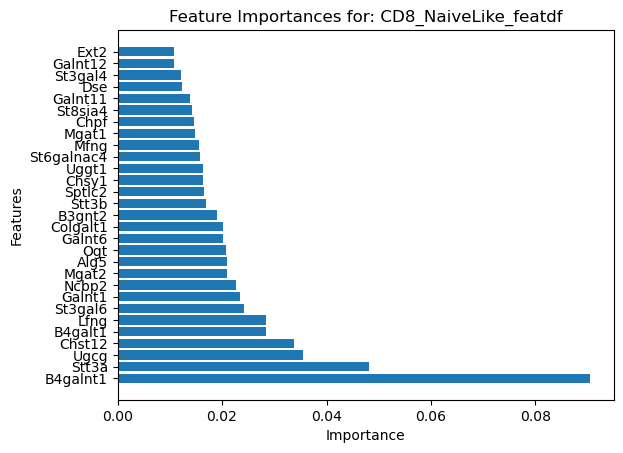

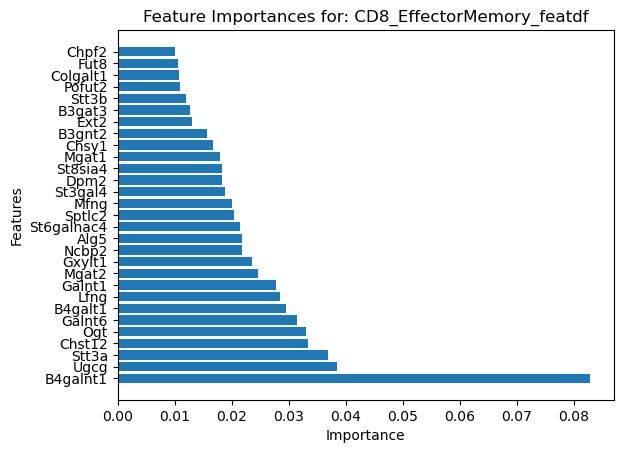

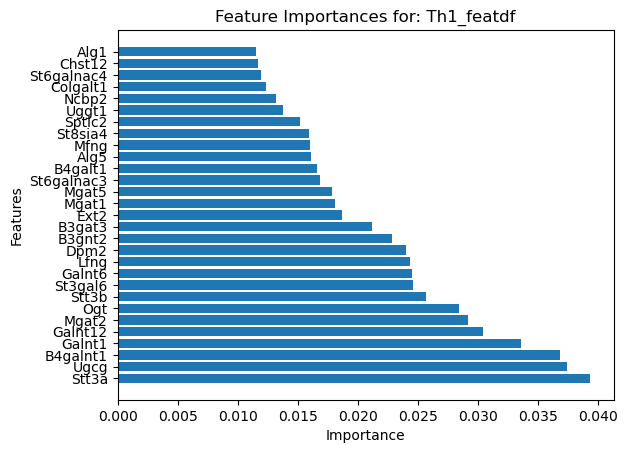

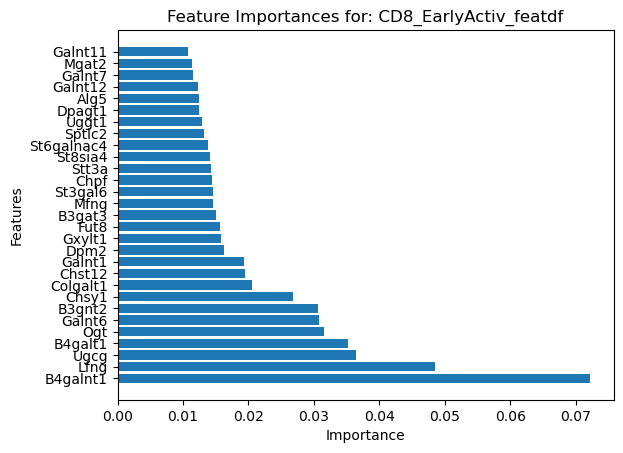

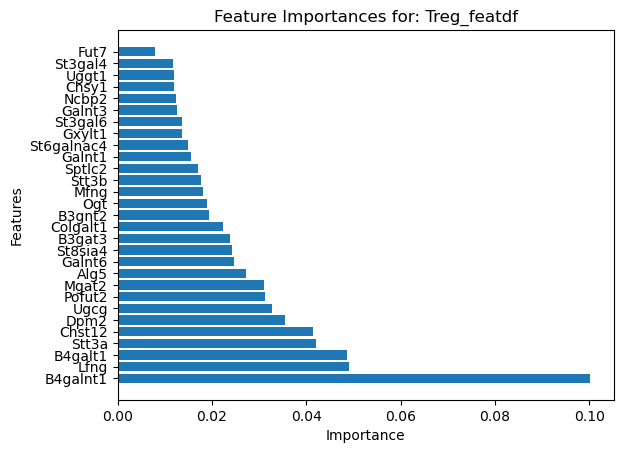

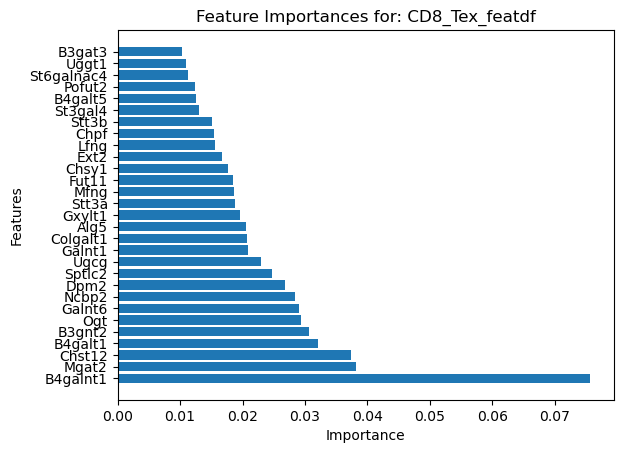

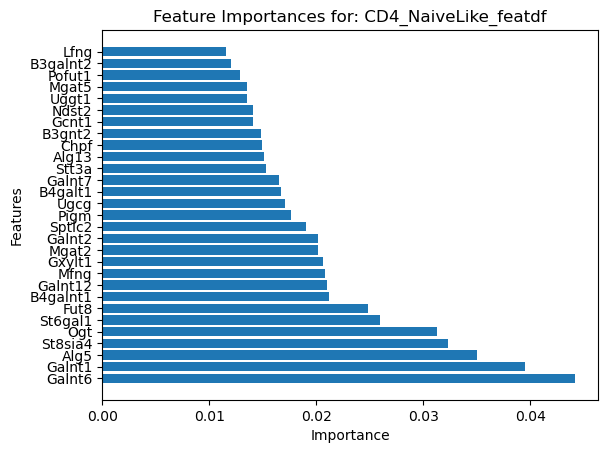

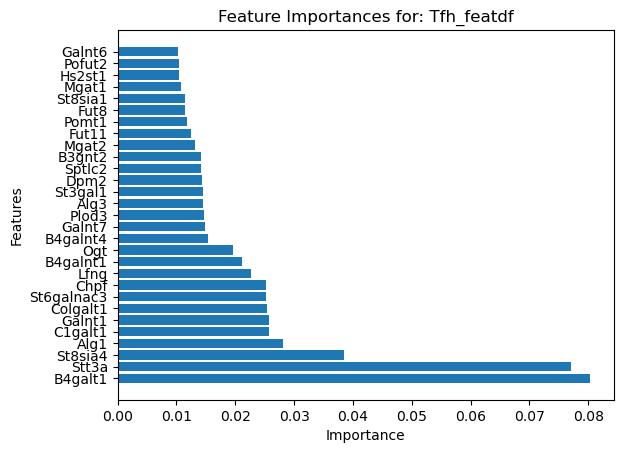

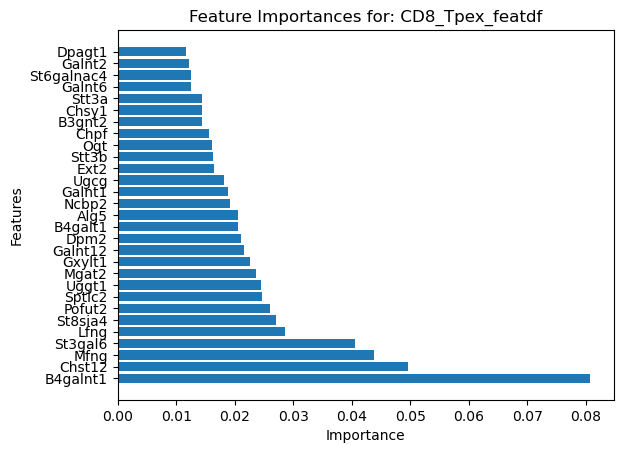

In [51]:
for name in df_names:
    df = feat_dfs[name][['feature', 'importance']].sort_values(by='importance', ascending=False)  
    df = df.head(30)
    vals = list(df['importance'])
    feats = list(df['feature'])
    fig, ax = plt.subplots()
    ax.barh(feats, vals)

    ax.set_title('Feature Importances for: '+ name)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.figure.savefig(output_path+'Glycogene feature importances for: '+ name)

In [52]:
# save pickle 
with open(pickle_path + 'feat_dfs.pkl', 'wb') as f:
    pickle.dump(feat_dfs, f)  

f.close()

# #open via: 
# #load updated df from pickle
# pickle_in = open(pickle_path + "feat_dfs.pkl","rb")
# feat_dfs = pickle.load(pickle_in)


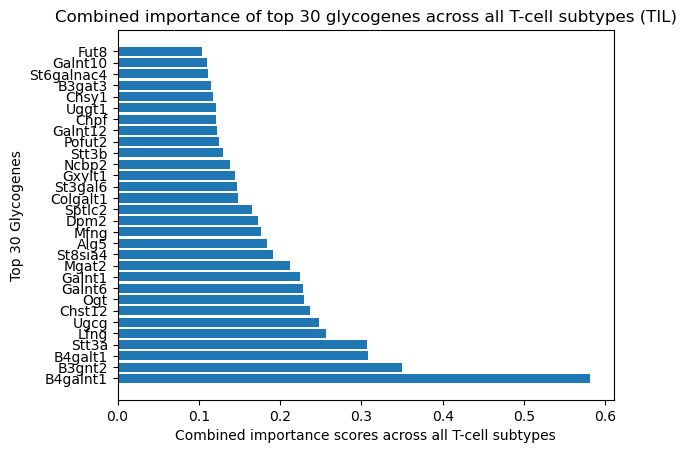

In [53]:
'''
GOAL is to identify key features across all of the different subtypes, to see if any are 
conserved as the most important across the subtypes.
Can either do it one of two ways:
- add up the importance values, and make barplot to look at which one has overall importance
- add up the index of sorted dataframe of each feature, so smallest bar in barplot indicates highest significance
'''
df_names = list(feat_dfs.keys())
combo_feat_importances = {}

#makes dictionary that contains total importance values from all the subtypes
for name in df_names:
    df = feat_dfs[name]
    for i in np.arange(len(df)):
        feat = df.iloc[i,0]
        imp = df.iloc[i,1]
        if feat not in combo_feat_importances.keys():
            combo_feat_importances[feat] = imp
        else:
            combo_feat_importances[feat] += imp
            
#makes dictionary into dataframe    
tot_importances = pd.DataFrame(combo_feat_importances, 
                               #columns = ['feature', 'combined importance'], 
                               index = ['combined importances'])
# sorted by the combined importance values
tot_importances = tot_importances.transpose().sort_values('combined importances', ascending = False)

#dropped genes with 0 importance combined
tot_importances = tot_importances.drop(index=tot_importances[(tot_importances == 0).any(axis=1)].index)

#undo scientific notation, and show up to 4 decimal points
tot_importances = tot_importances.round(4)

#this is a dataframe that combined the importance score of all the glycogenes across the different subtypes
tot_importances

# plot data as bar graph!!
fig, ax = plt.subplots()
top30 = tot_importances.head(30)
features = list(top30.index)
combo_imp = top30['combined importances']
ax.barh(features, combo_imp)
ax.set_title('Combined importance of top 30 glycogenes across all T-cell subtypes (TIL)')
ax.set_ylabel('Top 30 Glycogenes')
ax.set_xlabel('Combined importance scores across all T-cell subtypes')
plt.savefig(output_path + 'feature importances combined btw all subtypes (TIL)')

## C. Test each of the subtypes/all on all of the models made!!

In [54]:
model_list = [i+'_TILmodel' for i in subtype_names]
model_list

['CD8_NaiveLike_df_TILmodel',
 'CD8_EffectorMemory_df_TILmodel',
 'Th1_df_TILmodel',
 'CD8_EarlyActiv_df_TILmodel',
 'Treg_df_TILmodel',
 'CD8_Tex_df_TILmodel',
 'CD4_NaiveLike_df_TILmodel',
 'Tfh_df_TILmodel',
 'CD8_Tpex_df_TILmodel']

In [55]:
## load pickles of all of the models generated

#TIL all 
pickle_in = open(pickle_path + "TILmodel_all_robust.pkl","rb")
all_TILmodel = pickle.load(pickle_in)

# CD8 naive like
pickle_in = open(pickle_path + "CD8_NaiveLike_df_TILmodel.pkl","rb")
CD8_NaiveLike_df_TILmodel = pickle.load(pickle_in)

# CD8 effector memory like
pickle_in = open(pickle_path + "CD8_EffectorMemory_df_TILmodel.pkl","rb")
CD8_EffectorMemory_df_TILmodel = pickle.load(pickle_in)

# Th1
pickle_in = open(pickle_path + "Th1_df_TILmodel.pkl","rb")
Th1_df_TILmodel = pickle.load(pickle_in)

# CD8_EarlyActiv_df_TILmodel
pickle_in = open(pickle_path + "CD8_EarlyActiv_df_TILmodel.pkl","rb")
CD8_EarlyActiv_df_TILmodel = pickle.load(pickle_in)

# Treg_df_TILmodel
pickle_in = open(pickle_path + "Treg_df_TILmodel.pkl","rb")
Treg_df_TILmodel = pickle.load(pickle_in)

# CD8_Tex_df_TILmodel
pickle_in = open(pickle_path + "CD8_Tex_df_TILmodel.pkl","rb")
CD8_Tex_df_TILmodel = pickle.load(pickle_in)

# CD4_NaiveLike_df_TILmodel
pickle_in = open(pickle_path + "CD4_NaiveLike_df_TILmodel.pkl","rb")
CD4_NaiveLike_df_TILmodel = pickle.load(pickle_in)

# Tfh_df_TILmodel
pickle_in = open(pickle_path + "Tfh_df_TILmodel.pkl","rb")
Tfh_df_TILmodel = pickle.load(pickle_in)

# CD8_Tpex_df_TILmodel
pickle_in = open(pickle_path + "CD8_Tpex_df_TILmodel.pkl","rb")
CD8_Tpex_df_TILmodel = pickle.load(pickle_in)


model_df = [i+'_TILmodel' for i in subtype_names]
all_models = model_list + ['all_TILmodel']
all_models
CD8_NaiveLike_df_TILmodel

RandomForestClassifier(max_depth=40, min_samples_leaf=2, n_estimators=600)

In [56]:
'''
ITeratively test and make dataframe containing accuracy values of each model on each data type

input data: 
- glycoTIL_Z which is a dataframe of normalized counts of all T-cells from TIL
- glycoscored_dicts, a dictionary containing split normalized dfs
- models whose names are in all_models list 

output:
- dataframe containing columns/info for 

'''

cols = {"Model": [], "Input Data": [], "PHA-L high accuracy": [], "PHA-L low accuracy": [], 
        "Overall accuracy": [], 'Dimensions':[]}
total_dfs = pd.DataFrame(columns = cols)

glycoscored_dict['all_TILs_df'] = glycoTIL_Z #add all T-cells info into dictionary containing split dfs
data_names = list(glycoscored_dict.keys())

### CD8_NaiveLike_df_TILmodel ###

def subtype_modeltesting(model, model_name):
    for name in data_names:
        ## generate dataframe from dictionary key
        sub_df = glycoscored_dict[name]
        
        ## test random forest
        #y: PHA-L score array
        y = sub_df['PHA-L'].values 
        encoder = LabelEncoder()
        y_binary = encoder.fit_transform(y)

        #X: glycogene transcript data array
        x = sub_df.iloc[:, :-3].values

        #test model
        high, low, total = model_evaluation(model, x, y_binary)

        #save all the info into dataframe
        #get dimension 
        dim = sub_df.shape
        total_dfs.loc[len(total_dfs.index)] = [model_name, name, high, low, total, dim]

In [57]:
all_models

['CD8_NaiveLike_df_TILmodel',
 'CD8_EffectorMemory_df_TILmodel',
 'Th1_df_TILmodel',
 'CD8_EarlyActiv_df_TILmodel',
 'Treg_df_TILmodel',
 'CD8_Tex_df_TILmodel',
 'CD4_NaiveLike_df_TILmodel',
 'Tfh_df_TILmodel',
 'CD8_Tpex_df_TILmodel',
 'all_TILmodel']

In [58]:
subtype_modeltesting(CD8_NaiveLike_df_TILmodel, 'CD8_NaiveLike_df_TILmodel')
subtype_modeltesting(CD8_EffectorMemory_df_TILmodel, 'CD8_EffectorMemory_df_TILmodel')
subtype_modeltesting(Th1_df_TILmodel, 'Th1_df_TILmodel')
subtype_modeltesting(CD8_EarlyActiv_df_TILmodel, 'CD8_EarlyActiv_df_TILmodel')
subtype_modeltesting(Treg_df_TILmodel, 'Treg_df_TILmodel')
subtype_modeltesting(CD8_Tex_df_TILmodel, 'CD8_Tex_df_TILmodel')
subtype_modeltesting(CD4_NaiveLike_df_TILmodel, 'CD4_NaiveLike_df_TILmodel')
subtype_modeltesting(Tfh_df_TILmodel, 'Tfh_df_TILmodel')
subtype_modeltesting(CD8_Tpex_df_TILmodel, 'CD8_Tpex_df_TILmodel')
subtype_modeltesting(TILmodel_all_robust, 'all_TILmodel')

In [59]:
total_dfs=total_dfs.sort_values(by='Overall accuracy', ascending = False)
total_dfs.to_csv(output_path+'TIL_cross_accuracy.csv', index=False)

In [63]:
total_dfs.head(30)

,Model,Input Data,PHA-L high accuracy,PHA-L low accuracy,Overall accuracy,Dimensions
99,all_TILmodel,all_TILs_df,91.351241%,97.596741%,94.472720%,"(9824, 239)"
77,Tfh_df_TILmodel,Tfh_df,94.285714%,91.176471%,92.753623%,"(69, 239)"
55,CD8_Tex_df_TILmodel,CD8_Tex_df,90.211132%,94.990366%,92.596154%,"(1040, 239)"
88,CD8_Tpex_df_TILmodel,CD8_Tpex_df,88.732394%,96.453901%,92.579505%,"(283, 239)"
44,Treg_df_TILmodel,Treg_df,87.690743%,96.413934%,92.036753%,"(1959, 239)"
91,all_TILmodel,CD8_EffectorMemory_df,87.072808%,95.535714%,91.301115%,"(1345, 239)"
11,CD8_EffectorMemory_df_TILmodel,CD8_EffectorMemory_df,85.438336%,94.345238%,89.888476%,"(1345, 239)"
33,CD8_EarlyActiv_df_TILmodel,CD8_EarlyActiv_df,79.310345%,97.228637%,88.248848%,"(868, 239)"
22,Th1_df_TILmodel,Th1_df,82.942708%,93.394980%,88.131148%,"(1525, 239)"
66,CD4_NaiveLike_df_TILmodel,CD4_NaiveLike_df,91.044776%,80.303030%,85.714286%,"(133, 239)"


In [60]:
#total_dfs.sort_values(by='Overall accuracy', ascending = False).head(30)
fin = total_dfs.loc[total_dfs['Model']=='CD8_Tpex_df_TILmodel'].sort_values(by='Overall accuracy', ascending = False)